In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from sklearn.model_selection import KFold

In [22]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [23]:
import sys
case=2
a=2
cost='abs'

In [24]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [25]:
def cost_abs_transfer(H, A, T, P, Q, E_np_masked, case):
    A_transfer = np.multiply(A, P)
    A_transfer = A_transfer + Q
    HAT = multiply_case(H, A_transfer, T, case)
    mask = ~np.isnan(E_np_masked)
    error = (HAT - E_np_masked)[mask].flatten()
    return np.sqrt((error ** 2).mean())

In [33]:
def learn_HAT_transfer(case, E_np_masked, A_origin, a, b, num_iter=2000, lr=0.1, dis=False, cost_function='abs'):
    if cost_function == 'abs':
        cost = cost_abs_transfer
    else:
        cost = cost_rel
    mg = multigrad(cost, argnums=[0, 2, 3, 4])

    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)

    H = np.random.rand(*H_dim)
    T = np.random.rand(*T_dim)
    P = np.random.rand(*A_dim)
    Q = np.random.rand(*A_dim)
    A = A_origin

	# GD procedure
    for i in range(num_iter):
        del_h, del_t, del_p, del_q = mg(H, A, T, P, Q, E_np_masked, case)
        H -= lr * del_h
        T -= lr * del_t
        P -= lr * del_p
        Q -= lr * del_q

        H[H < 0] = 0
        T[T < 0] = 0
        P[P < 0] = 0
        Q[Q < 0] = 0
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, P, Q, E_np_masked, case))
    return H, A, T, P, Q

In [34]:
au_df, au_dfc = create_matrix_single_region(region, year)
au_tensor = get_tensor(au_df, au_dfc)

### Learning H, A, T from Austin

In [35]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

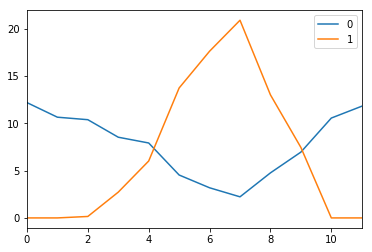

In [36]:
pd.DataFrame(T_a).plot();

In [37]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)

In [38]:
kf = KFold(n_splits=2)

In [72]:
from scipy.optimize import nnls
pred = {}
for appliance_name, appliance_id in appliance_index.iteritems():
    pred[appliance_name] = []

for train, test in kf.split(sd_df):
    train_ix = sd_df.index[train]
    test_ix = sd_df.index[test]
    
    # Learning T from train SD homes, using A_a from Austin as known
    train_df = sd_df.ix[train_ix]
    test_df = sd_df.ix[test_ix]
    test_dfc = sd_dfc.ix[test_ix]
    train_dfc = sd_dfc.ix[train_ix]
    t_sd_train = get_tensor(train_df, train_dfc)
#     H_sd_train, A_sd_train, T_sd_train = learn_HAT(case, t_sd_train, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
    H_sd_train, A_sd_train, T_sd_train, P, Q = learn_HAT_transfer(case, t_sd_train, A_a, a, a, num_iter = 5000,lr=0.005, dis=False, cost_function=cost)
    # Now, for the test homes, we will use T_sd_train and A_a and aggregate data to learn H_sd_test
    t_sd_test = get_tensor(test_df, test_dfc)
    # Refer to https://nipunbatra.github.io/blog/2017/nmf-nnls.html for NNLS and the variable names used
    A_sd = np.multiply(A_sd_train, P)
    A_sd = A_sd + Q
    
    
    # A_mat contains GT aggregate power
    A_mat = t_sd_test[:, 0, :]
    # H_mat is the "known"
    H_mat = np.einsum('ab, Ob -> aO', A_sd[0], T_sd_train)
    M = len(test_df)
    # We want to estimate W_mat (Home factor); which we do using NNLS
    W_mat = np.zeros((M, 2))
    
    for j in range(M):
        mask_rows = pd.Series(A_mat[j,:]).notnull()
        W_mat[j,:] = nnls(H_mat.transpose()[mask_rows], A_mat[j,:][mask_rows])[0]
    pred_overall = np.einsum('Ma, Nab, Ob -> MNO', W_mat, A_sd, T_sd_train)
    
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
for appliance_name, appliance_id in appliance_index.iteritems():
    pred[appliance_name] = pd.concat(pred[appliance_name]).ix[sd_df.index]
    

In [73]:
P

array([[[ 2.37417246,  0.79066212],
        [ 1.58114946,  4.03079824]],

       [[ 0.06391191,  1.11572431],
        [ 0.12317965,  3.13550597]],

       [[ 4.16540695,  1.49067842],
        [ 1.5006123 ,  0.75684099]],

       [[ 0.82376895,  0.98817012],
        [ 0.26412573,  0.47242885]],

       [[ 1.08763148,  0.80641084],
        [ 0.79719435,  0.27703241]],

       [[ 0.571063  ,  0.18566572],
        [ 0.18839952,  0.43536239]],

       [[ 1.15294608,  0.5281936 ],
        [ 1.18057419,  0.82222828]]])

In [74]:
Q

array([[[ 0.10479413,  0.59796165],
        [ 0.69907926,  1.09109311]],

       [[ 0.        ,  0.84381893],
        [ 0.        ,  0.19621689]],

       [[ 2.99666643,  2.12864129],
        [ 1.71430557,  0.45648645]],

       [[ 1.20171899,  0.29780464],
        [ 0.66957598,  0.36676192]],

       [[ 0.75321687,  0.28374494],
        [ 0.60712074,  0.82317045]],

       [[ 0.5862633 ,  0.87833186],
        [ 0.33164938,  0.75445923]],

       [[ 0.96422618,  0.4750988 ],
        [ 0.67760234,  0.75534326]]])

In [75]:
pred['mw'].head()

,0,1,2,3,4,5,6,7,8,9,10,11
54,5.410615,4.861556,5.300210,5.072027,5.831524,5.238514,6.419957,6.805086,7.559669,6.334934,5.376748,5.989003
203,6.120843,5.503166,5.882640,5.592543,6.240996,5.618858,6.727149,7.087908,7.936365,6.892726,6.051166,6.776090
527,14.572143,13.088588,14.432244,13.862107,16.200472,14.535656,18.034738,19.176102,21.215578,17.442000,14.524515,16.128583
1450,13.258084,11.912388,12.997030,12.440570,14.319266,12.862088,15.776178,16.726162,18.575613,15.545931,13.177720,14.675276
1524,10.480258,9.432790,9.740078,9.149619,9.641817,8.719453,9.947683,10.345634,11.783198,10.998934,10.268962,11.604938


In [76]:
from common import compute_rmse_fraction

In [77]:
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    print appliance
    if appliance=="hvac":
        out[appliance] = compute_rmse_fraction(appliance, pred[appliance][range(4, 10)],'SanDiego')[2]
    else:   
        out[appliance] = compute_rmse_fraction(appliance, pred[appliance],'SanDiego')[2]

hvac
fridge
mw
dw
wm
oven


In [78]:
pd.Series(out)

dw         2.116783
fridge     6.918636
hvac      21.427419
mw         2.703579
oven       4.367263
wm         1.189498
dtype: float64

In [79]:
pred[appliance]

,0,1,2,3,4,5,6,7,8,9,10,11
54,8.313124,7.452385,8.705541,8.513502,10.725806,9.573035,12.520421,13.483809,14.668868,11.091319,8.416674,9.197135
203,9.252352,8.301559,9.453192,9.172906,11.196376,10.014789,12.819965,13.736200,15.044368,11.774416,9.302296,10.238192
527,22.600551,20.250499,23.995231,23.565620,30.189868,26.914931,35.588235,38.424138,41.660888,30.945623,22.972816,25.001164
1450,20.383065,18.272005,21.364982,20.899688,26.360791,23.525807,30.792317,33.167517,36.074081,27.242666,20.642425,22.550421
1524,15.396287,13.835574,15.027192,14.362387,16.421427,14.757592,18.008827,19.068417,21.213127,17.893784,15.284710,17.042583
1731,14.927808,13.388180,15.435910,15.035618,18.642648,16.657134,21.553795,23.153767,25.272786,19.441664,15.059341,16.516846
2031,6.472308,5.809888,6.524626,6.303683,7.555162,6.766515,8.551206,9.133834,10.044910,8.023519,6.482837,7.162663
2354,15.290688,13.706812,16.034847,15.687930,19.798721,17.668763,23.135076,24.921868,27.102619,20.454789,15.487344,16.916503
2606,13.037449,11.689066,13.603325,13.288173,16.665562,14.878978,19.401544,20.879657,22.735917,17.274760,13.186129,14.424252
3687,15.251575,13.668456,16.101849,15.786291,20.087475,17.916524,23.586442,25.440092,27.620201,20.663461,15.477628,16.872337


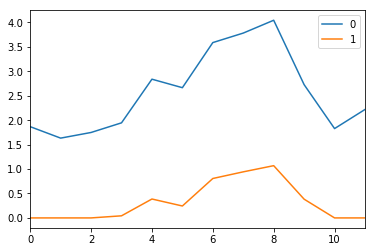

In [63]:
pd.DataFrame(T_sd_train).plot()

In [64]:
from degree_days import dds

In [36]:
dds[2014]['SanDiego']

[0.08259212198221093,
 0.0698856416772554,
 0.17280813214739518,
 0.20584498094027953,
 0.38373570520965694,
 0.33290978398983484,
 0.5438373570520966,
 0.5501905972045743,
 0.5997458703939009,
 0.47522236340533675,
 0.22363405336721728,
 0.08767471410419314]

In [37]:
df_corr = pd.DataFrame(T_sd_train)

In [39]:
df_corr['weather'] = dds[2014]['SanDiego']

In [41]:
df_corr.corr()

,0,1,weather
0,1.000000,-0.585948,-0.442960
1,-0.585948,1.000000,0.926306
weather,-0.442960,0.926306,1.000000
